As a first check that our Hamiltonian solver matches the expectations we have from experiment, let us find the response of a linear resonator to a driving term.

We have a few parameters.

- cavity frequency $\omega_c$
- drive frequency $\omega_1$
- drive power $\epsilon$
- drive phase $\phi_1$
- cavity dissipation rate $\kappa$

We should observe that
- sweeping drive frequency should produce a response with a width of $\kappa$


Text(0.5, 0, 'Time')

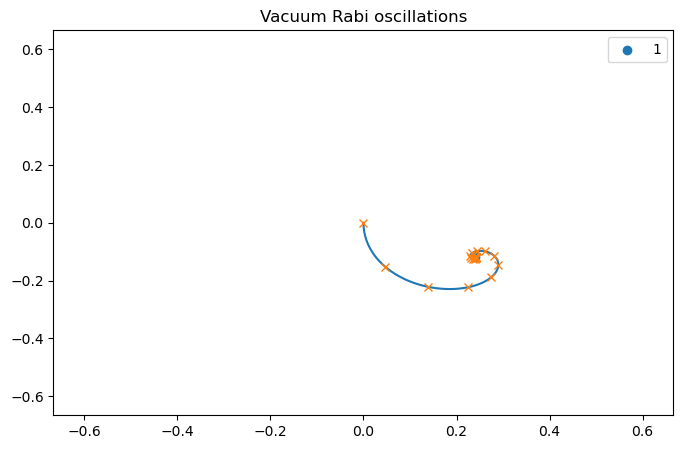

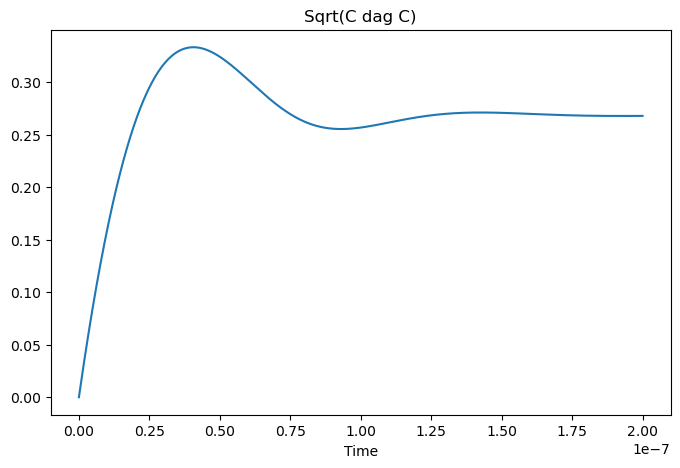

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

def cav_drive(m, w_c, w_1, epsilon, phi_1, kappa):

    N = 25

    c  = destroy(N)

    tlist = np.linspace(0,2e-7,20000)

    H0 = w_c * c.dag() * c

    H1_I = c # quadratures of the drive

    H1_Q = c.dag()

    cav_drive = epsilon*np.exp(1j*w_1*tlist + 1j*phi_1)

    H = [[H0, tlist*0 + 1],[H1_I,cav_drive],[H1_Q,np.conj(cav_drive)]]

    H0.eigenenergies()/(2*np.pi)

    c_op_list = []

    rate = kappa
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * c)

    psi_0 = coherent(N,0)

    output1 = mesolve(H, psi_0, tlist, c_ops = c_op_list, e_ops = [(c.dag() + c)/2, 1j*(c.dag() - c)/2, c.dag()*c])

    x = output1.expect[0]*np.sqrt(2 / (m*w_c))
    p = output1.expect[1]*np.sqrt(2*m*w_c)
    
    I = output1.expect[0]
    Q = output1.expect[1]
    
    x1 = I + 1j*Q
    
    return x1, tlist

epsilon = 3e6 * 2 * np.pi # note how the power has units of frequency here - a rate of photon addition
w_c  = 2 * np.pi * 5e9 # resonator frequency
w_1 = 2 * np.pi * 5.01e9  # drive
phi_1 = 0*np.pi/2 # phase
kappa = 10e6 * 2 * np.pi           # cavity dissipation rate
m=0.0000000001  # just a value that keeps the sim stable, doesn't affect the quadratures

x1, tlist = cav_drive(m, w_c, w_1, epsilon, phi_1, kappa)
    
fig, ax = plt.subplots(figsize=(8,5))

w_demod = w_1

demod1 = (x1*np.exp(1j*w_demod*tlist))

limits = np.max(np.abs(demod1))*2

ax.plot(np.real(demod1), np.imag(demod1))
ax.plot(np.real(demod1[0:-1:1000]), np.imag(demod1)[0:-1:1000],'x')
ax.scatter(np.real(demod1[-1]), np.imag(demod1[-1]), label="1")
ax.legend()
ax.set_title('Vacuum Rabi oscillations')
ax.set_xlim([-limits,limits])
ax.set_ylim([-limits,limits])

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(tlist, np.abs(x1))
ax.set_xlabel('Time')
ax.set_title('Sqrt(C dag C)')
ax.set_xlabel('Time')

In [2]:
x1

array([ 0.00000000e+00+0.j        , -5.81761838e-05-0.00017862j,
       -2.21415033e-04-0.00030436j, ...,  2.64143061e-01+0.0442445j ,
        2.64861844e-01-0.03971676j,  2.39548425e-01-0.11977379j])

Note that the resonator picks up 2$\pi$/10 photons in 0.1 us, because the drive strength is 2$\pi$ MHz.

31353094682.826134
31384510609.362034
31415926535.89793
31447342462.43383
31478758388.969727


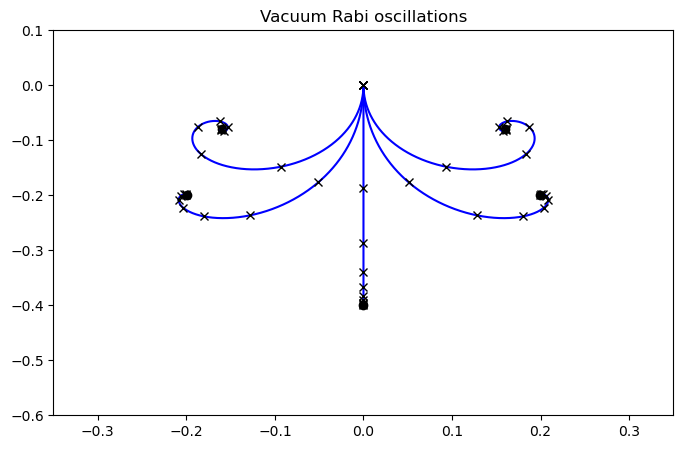

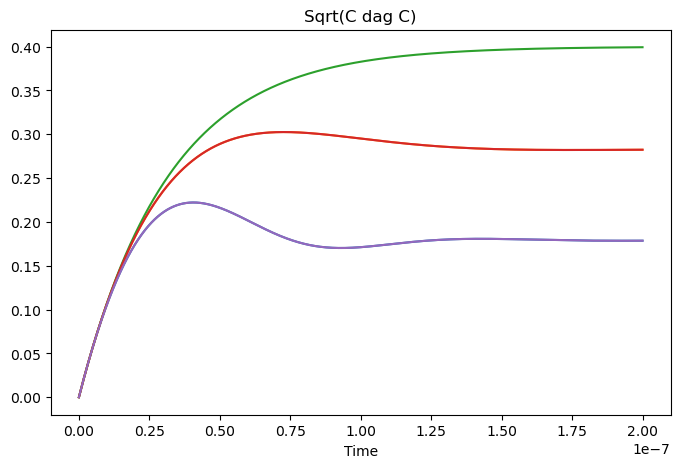

In [3]:
epsilon = 2e6 * 2 * np.pi # note how the power has units of frequency here - a rate of photon addition
w_c  = 2 * np.pi * 5e9 # resonator frequency
w_1 = 2 * np.pi * (5.00e9 + np.linspace(-10e6, 10e6, 5) ) # drive
phi_1 = 0*np.pi/2 # phase
kappa = 10e6 * 2 * np.pi           # cavity dissipation rate

fig1, ax1 = plt.subplots(figsize=(8,5))
fig2, ax2 = plt.subplots(figsize=(8,5))

limits = 0

for w_1_i in w_1:
    print(w_1_i)
    x1, tlist = cav_drive(m, w_c, w_1_i, epsilon, phi_1, kappa)

    w_demod = w_1_i

    demod1 = x1*np.exp(1j*w_demod*tlist)

    limits = np.max([np.max(np.abs(demod1))*2, limits])

    ax1.plot(np.real(demod1), np.imag(demod1),color='b')
    ax1.plot(np.real(demod1[0:-1:2000]), np.imag(demod1)[0:-1:2000],'x',color='k')
    ax1.scatter(np.real(demod1[-1]), np.imag(demod1[-1]), label="1",color='k')
    ax1.set_title('Vacuum Rabi oscillations')
    ax1.set_xlim([-0.35,0.35])
    ax1.set_ylim([-0.6,0.1])

    ax2.plot(tlist, np.abs(x1))
    ax2.set_xlabel('Time')
    ax2.set_title('Sqrt(C dag C)')
    ax2.set_xlabel('Time')

Let's compare this to the classical case.

Given the drive Hamiltonian

$$
H =  \omega c^{\dagger} c + \epsilon ( c^{\dagger} e^{- i \omega_1 t} + c e^{i \omega_1 t} )
$$

we can transform back to the position and momentum basis with the defintion of ladder operators

$$
c = \frac{1}{\sqrt{2 m \omega }} (ip + m\omega x)
$$

$$
c^{\dagger} = \frac{1}{\sqrt{2 m \omega }} (-ip + m\omega x)
$$

After the transformation we get

$$
H = \frac{p^2}{2 m} + \frac{1}{2} m \omega x^2 + \frac{2 \epsilon}{\sqrt{2 m \omega}} \left( m \omega x \cos( \omega_1 t) - p \sin (\omega_1 t) \right)
$$

Nothing about this is classical yet - if we interpret the operators $x$ and $p$ as numbers, however, this is a classical drive Hamiltonian. The equations of motion are given by Hamilton's equations

$$
\frac{dx}{dt} = \frac{\partial H}{\partial p}
$$
and
$$
\frac{dp}{dt} = - \frac{\partial H}{\partial x}
$$

We get

$$
\dot{x} = mp - \frac{2 \epsilon}{\sqrt{2 m \omega}} \sin(\omega_1 t)
$$
and
$$
\dot{p} = -m\omega x - \frac{2 \epsilon}{\sqrt{2 m \omega}} \cos(\omega_1 t)
$$

We can simulate this numerically, as shown below.

Text(0.5, 0, 'Time')

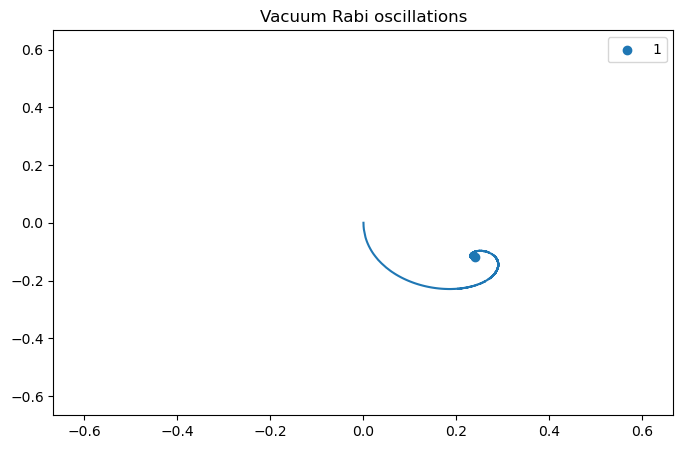

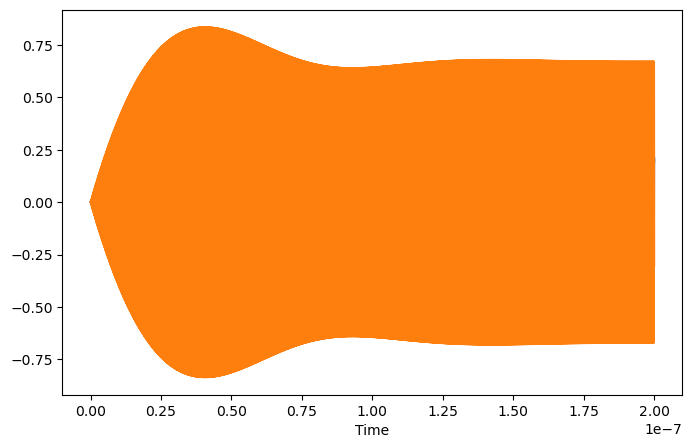

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq
import time
from numba import njit
from numba.typed import List

@njit
def RK_loop(t, x, f_dxdt, dt, args):

    '''
    Implements an RK4 method.
    '''

    for i in range(0, len(t)-1):#

        k1 = f_dxdt(x[i,:], t[i], args)
        k2 = f_dxdt(x[i,:] + k1*dt/2, t[i] + dt/2, args) 
        k3 = f_dxdt(x[i,:] + k2*dt/2, t[i] + dt/2, args) 
        k4 = f_dxdt(x[i,:] + k3*dt, t[i] + dt, args) 
        
        x[i+1,:] = x[i,:] + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

    return x

@njit
def f_dxdt(xi, t, args):
    
    m = args[0]
    w_c = args[1]
    w_1 = args[2]
    kappa = args[3]
    epsilon = args[4]
    phi_1 = args[5]

    xx = xi[0]
    p = xi[1]

    dxxdt = p/m - 2*epsilon/np.sqrt(2*m*w_c)*np.sin(w_1*t)
    dpdt = -m*w_c**2*xx - 2*epsilon/np.sqrt(2*m*w_c)*m*w_c*np.cos(w_1*t) - kappa*p
    
    dxdt = np.array([dxxdt, dpdt])

    return dxdt

def classical_cav_drive_i(args):
    '''
    Wrapper for the RK loop that creates all the necessary arrays, since
    you can't create arrays inside of a jit function.
    '''
    
    t = np.linspace(0,2e-7,200000)
    
    N = 2
    
    x0 = np.zeros(2)
    
    x = np.zeros([len(t),N])
    
    dt = t[1] - t[0]
    
    x[0,:] = x0

    result = RK_loop(t, x, f_dxdt, dt, args)
    
    x = result[:,0]
    p = result[:,1]
    
    I = x*np.sqrt(m*w_c/2)
    Q = p/np.sqrt(2*w_c*m)

    traj = I + 1j*Q
    
    return t, traj, I, Q, x, p

def classical_cav_drive(m,w_c,w_1,kappa, epsilon, phi_1):
    
    args_list = [m,w_c,w_1,kappa, epsilon, phi_1]

    args = List()
    [args.append(arg) for arg in args_list]

    t, traj, I, Q, x, p = classical_cav_drive_i(args)
    
    return t, traj, I, Q, x, p



epsilon = 3e6 * 2 * np.pi # note how the power has units of frequency here - a rate of photon addition
w_c  = 2 * np.pi * 5e9 # resonator frequency
w_1 = 2 * np.pi * 5.01e9  # drive
phi_1 = 0*np.pi/2 # phase
kappa = 10e6 * 2 * np.pi           # cavity dissipation rate
m=0.0000000001  # just a value that keeps the sim stable, doesn't affect the IQ quadratures

tlist, traj, I, Q, x, p = classical_cav_drive(m, w_c, w_1, kappa, epsilon, phi_1)

w_demod = w_1

demod1 = (traj*np.exp(1j*w_demod*tlist))

limits = np.max(np.abs(demod1))*2

fig1, ax1 = plt.subplots(figsize=(8,5))
fig2, ax2 = plt.subplots(figsize=(8,5))

ax1.plot(np.real(demod1), np.imag(demod1))
ax1.scatter(np.real(demod1[-1]), np.imag(demod1[-1]), label="1")
ax1.legend()
ax1.set_title('Vacuum Rabi oscillations')
ax1.set_xlim([-limits,limits])
ax1.set_ylim([-limits,limits])

ax2.plot(tlist, x)
ax2.plot(tlist, p)
ax2.set_xlabel('Time')
ax2.set_xlabel('Time')

30787608005.179974
30927234345.33952
31066860685.499065
31206487025.658615
31346113365.81816
31485739705.977703
31625366046.13725
31764992386.296795
31904618726.456345
32044245066.61589


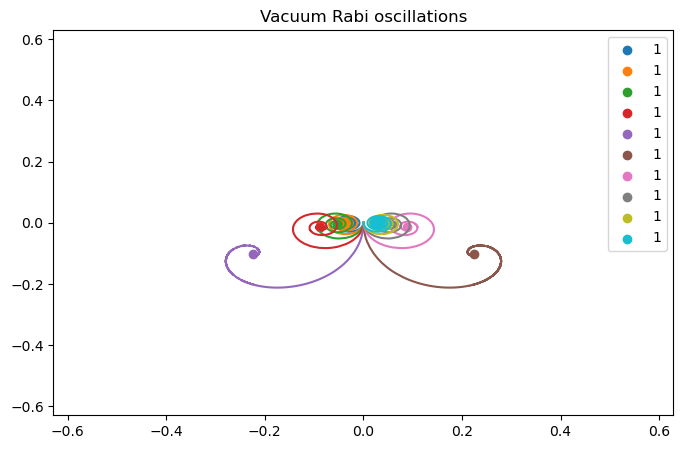

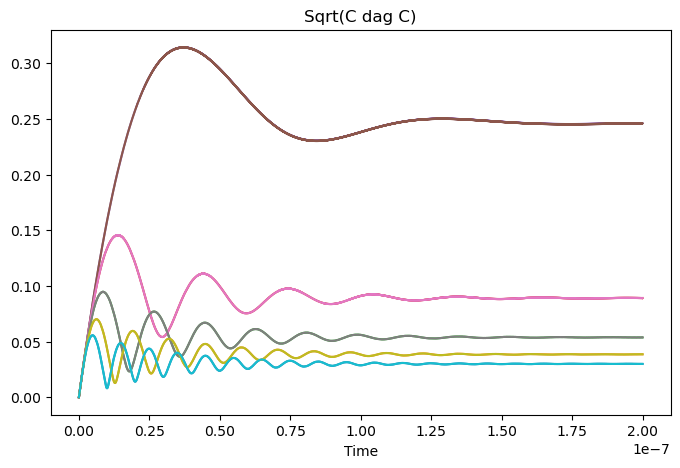

In [5]:
epsilon = 3e6 * 2 * np.pi # note how the power has units of frequency here - a rate of photon addition
w_c  = 2 * np.pi * 5e9 # resonator frequency
w_1 = 2 * np.pi * (5.00e9 + np.linspace(-100e6, 100e6, 10) ) # drive
phi_1 = 0*np.pi/2 # phase
kappa = 10e6 * 2 * np.pi           # cavity dissipation rate
m=0.0000000001  # just a value that keeps the sim stable, doesn't affect the quadratures

fig1, ax1 = plt.subplots(figsize=(8,5))
fig2, ax2 = plt.subplots(figsize=(8,5))

limits = 0

for w_1_i in w_1:
    print(w_1_i)
    tlist, traj, I, Q, x, p = classical_cav_drive(m,w_c,w_1_i,kappa, epsilon, phi_1)

    w_demod = w_1_i

    demod1 = (traj*np.exp(1j*w_demod*tlist))

    limits = np.max([np.max(np.abs(demod1))*2, limits])

    ax1.plot(np.real(demod1), np.imag(demod1))
    ax1.scatter(np.real(demod1[-1]), np.imag(demod1[-1]), label="1")
    ax1.legend()
    ax1.set_title('Vacuum Rabi oscillations')
    ax1.set_xlim([-limits,limits])
    ax1.set_ylim([-limits,limits])

    ax2.plot(tlist, np.abs(traj))
    ax2.set_xlabel('Time')
    ax2.set_title('Sqrt(C dag C)')
    ax2.set_xlabel('Time')